<a href="https://colab.research.google.com/github/xli2522/GW-SignalGen/blob/main/GW_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  
#  Generating Gravitational Wave Signals with Noise 
#####(for GW Classifier Training) 
##### © Xiyuan Li 2021, Department of Physics and Astronomy, Western University (UWO), London, Ontario, Canada
##### Resources: 
[PyCBC](http://github.com/ligo-cbc/pycbc) + additional PyCBC [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html).

##### Code *Reference*:
[gw-odw/odw-2020](http://github.com/gw-odw/odw-2020)

In [4]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'

     |████████████████████████████████| 3.1MB 4.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5MB 117kB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 890kB 41.0MB/s 
     |████████████████████████████████| 1.6MB 37.2MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 3.2MB 31.5MB/s 


In [105]:
# Initialization
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as learn
import time
import tqdm    #progress bar

## 1 Generating GW Waveforms
### 1.1 Generating GW Waveform using SEOBNRv4
##### [PyCBC.waveform.getwaveform Doc](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#module-pycbc.waveform.waveform)
###### Unused parameters include spin, tidal deformability, monopole, and more.

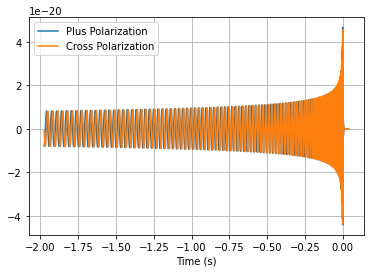

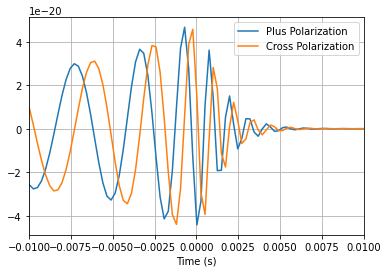

<class 'pycbc.types.timeseries.TimeSeries'>
0


In [96]:
# Generating one example waveform 
# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=5)

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

# verify container type and data extraction
print(type(hc))
testing_container = np.zeros(2, dtype=object)
print(testing_container[0])
testing_container[0], testing_container[1] = hp, hc
print(testing_container)

### 1.2 Generating N GW Waveforms using SEOBNRv4 and IMRPhenomD
#### Binary Mass Ratio Range

In [97]:
#Unison Shuffle if not using sklearn
def unisonShuffle(a, b):
    rng_state = np.random.get_state()
    permu_a = np.random.shuffle(a)
    np.random.set_state(rng_state)
    permu_b = np.random.shuffle(b)

    return permu_a, permu_b

#testing
#1. unisonShuffle
a, b = unisonShuffle(np.arange(10), np.arange(10))
print(a==b)

True


In [100]:
# Generate a set of N parameter inputs
# Upper limit: Y = X
# Lower limit: Y = .2*X 
# k parameter interval 0.1
# X range= [5, 40]
# Interval: ...

for i in range(9):
  m1 = np.linspace(5, 40, 100)
  m2 = (0.2+0.1*i)*m1
  if i == 0:
      sum_m1 = m1
      sum_m2 = m2
  else:
      sum_m1 = np.asarray(np.concatenate((sum_m1, m1), axis=0))
      sum_m2 = np.asarray(np.concatenate((sum_m2, m2), axis=0))

np.random.seed(5625)
unisonShuffle(sum_m1, sum_m2)

#total pairs of masses
N = len(sum_m1)
print('Total # of Masses ' + str(N))

Total # of Masses 900


In [101]:
#Generate training and testing sets
training_m1 = sum_m1[int(N/3):]
training_m2 = sum_m2[int(N/3):]
testing_m1 = sum_m1[:int(N/3)]
testing_m2 = sum_m2[:int(N/3)]
print('# of Traning masses ' + str(len(training_m1)))
print('# of Testing masses ' + str(len(testing_m1)))

# of Traning masses 600
# of Testing masses 300


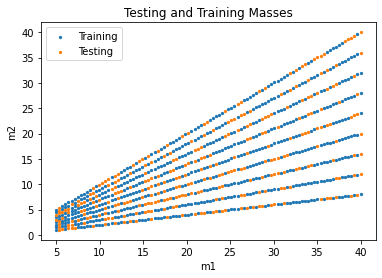

In [102]:
#Plot Training and Testing Masses
plt.figure()
plt.scatter(training_m1, training_m2, c=b,s=5)
plt.scatter(testing_m1, testing_m2,s=5)
plt.xlabel('m1')
plt.ylabel('m2')
plt.legend(['Training', 'Testing'])
plt.title('Testing and Training Masses')
plt.show()

##### Generate Training and Testing Data

In [110]:
%%capture
from tqdm import tqdm.notebook.tqdm as tqdm
tqdm().pandas()

###### Training Times Series

In [113]:
# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx = 'IMRPhenomD'

start_time = time.time()
# You can specify many parameters, 
# https://pycbc.org/pycbc/latest/html/pycbc.waveform.html?highlight=get_td_waveform#pycbc.waveform.waveform.get_td_waveform
# but here, we'll use defaults for everything except the masses.
# It returns both hplus and hcross, but we'll only use hplus for now.
# Training Data
training_series = np.zeros(len(training_m1), dtype=object)
with tqdm(total=len(training_m1)) as pbar:
    for i in range(len(training_m1)):
        hp1, _ = get_td_waveform(approximant=apx,
                                mass1=training_m1[i],
                                mass2=training_m2[i],
                                delta_t=1.0/sample_rate,
                                f_lower=25)

        # The amplitude of gravitational-wave signals is normally of order 1E-20. To demonstrate our method
        # on white noise with amplitude O(1) we normalize our signal so the cross-correlation of the signal with
        # itself will give a value of 1. In this case we can interpret the cross-correlation of the signal with white
        # noise as a signal-to-noise ratio.

        hp1 = hp1 / max(np.correlate(hp1,hp1, mode='full'))**0.5
        training_series[i] = hp1
        pbar.update(1)

print("--- %s seconds ---" % (time.time() - start_time))
print('Generated '+str(len(training_series))+' training times series.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



--- 206.43250036239624 seconds ---
Generated 600 training times series.


###### Testing Time Series

In [114]:
start_time = time.time()
testing_series = np.zeros(len(testing_m1), dtype=object)
with tqdm(total=len(testing_m1)) as pbar:
    for i in range(len(testing_m1)):
        hp1, _ = get_td_waveform(approximant=apx,
                                mass1=testing_m1[i],
                                mass2=testing_m2[i],
                                delta_t=1.0/sample_rate,
                                f_lower=25)

        # The amplitude of gravitational-wave signals is normally of order 1E-20. To demonstrate our method
        # on white noise with amplitude O(1) we normalize our signal so the cross-correlation of the signal with
        # itself will give a value of 1. In this case we can interpret the cross-correlation of the signal with white
        # noise as a signal-to-noise ratio.

        hp1 = hp1 / max(np.correlate(hp1,hp1, mode='full'))**0.5
        testing_series[i] = hp1
        pbar.update(1)

print("--- %s seconds ---" % (time.time() - start_time))
print('Generated '+str(len(testing_series))+' testing times series.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



--- 133.47324061393738 seconds ---
Generated 300 testing times series.


###### Random sampling

In [116]:
'''
n = 6    #number of samples
learn_sample=[]
for i in np.random.randint(0, len(learning_series), n):
    test_sample.append(learing_series[i])
# Visulization
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
 ax = fig.add_subplot(2, 3, n)
    
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()'''

"\nn = 6    #number of samples\nlearn_sample=[]\nfor i in np.random.randint(0, len(learning_series), n):\n    test_sample.append(learing_series[i])\n# Visulization\nfig = plt.figure()\nfig.subplots_adjust(hspace=0.4, wspace=0.4)\n ax = fig.add_subplot(2, 3, n)\n    \npylab.plot(hp.sample_times, hp, label='Plus Polarization')\npylab.plot(hp.sample_times, hc, label='Cross Polarization')\npylab.xlabel('Time (s)')\npylab.legend()\npylab.grid()\npylab.show()"

### 1.3 Generating White Noise and Gaussian Noise
##### *Reference*:
[gw-odw/odw-2020](http://github.com/gw-odw/odw-2020)

In [90]:
# specify the sample rate.
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# It captures signal frequency content up to f_Nyquist = 8192 Hz.
# Here, we will make the computation faster by sampling at a lower rate.
sample_rate = 1024 # samples per second
data_length = 1024 # seconds

# Generate a long stretch of white noise: the data series and the time series.
data = np.random.normal(size=[sample_rate * data_length])
times = np.arange(len(data)) / float(sample_rate)

Text(0, 0.5, 'Normalized amplitude')

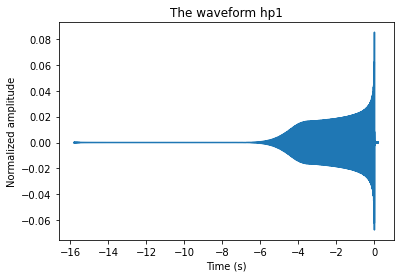

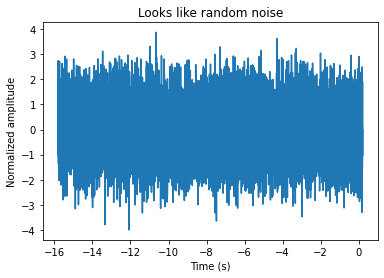

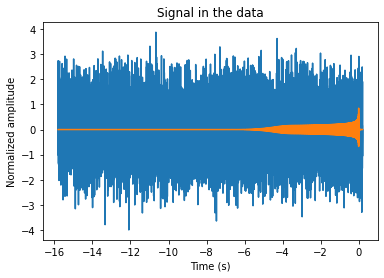

In [117]:
# note that in this figure, the waveform amplitude is of order 1.
# The duration (for frequency above f_lower=25 Hz) is only 3 or 4 seconds long.
# The waveform is "tapered": slowly ramped up from zero to full strength, over the first second or so.
# It is zero-padded at earlier times.
pylab.figure()
pylab.title("The waveform hp1")
pylab.plot(hp1.sample_times, hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

# Shift the waveform to start at a random time in the Gaussian noise data.
waveform_start = np.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

pylab.figure()
pylab.title("Looks like random noise")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

pylab.figure()
pylab.title("Signal in the data")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.plot(hp1.sample_times, 10 * hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

### 1.4 Generating Advanced LIGO Noise
